# House Price Prediction Model:-

Name - Gaurav Kumar Rampuria
<br>Roll No. - 230413

# Setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

# Pre Processing

In [49]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

X = train_data.drop(['SalePrice'], axis = 1)
y = train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def preprocess(data):
  # We will first perform Feature Engineering
  data['SF'] = data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
  data['Bath'] = data['FullBath'] + 0.5 * data['HalfBath']
  data['Luxury'] = 0

  for i in data.index:
    # Luxury - Miscellaneous Features, Fireplace, Pool, CentralAir,  etc. - Metric of luxurious features
    if(data['MiscFeature'][i]=='Shed'):
      data['Luxury'][i] += 1
    elif(data['MiscFeature'][i]=='Gar2'):
      data['Luxury'][i] += 1
    elif(data['MiscFeature'][i]=='TenC'):
      data['Luxury'][i] += 2
    elif(data['MiscFeature'][i]=='Othr'):
      data['Luxury'][i] += 1

    # Central Air Conditioning
    if(data['CentralAir'][i] == 'Y'):
      data['Luxury'][i] += 1

    if(data['HeatingQC'][i]=='Ex'):
      data['Luxury'][i]+=1
    elif(data['HeatingQC'][i]=='Gd'):
      data['Luxury'][i]+=0.8
    elif(data['HeatingQC'][i]=='TA'):
      data['Luxury'][i]+=0.6
    elif(data['HeatingQC'][i]=='Fa'):
      data['Luxury'][i]+=0.4
    elif(data['HeatingQC'][i]=='Po'):
      data['Luxury'][i]+=0.2

    data['Luxury'][i] += data['Fireplaces'][i]

  final_params = data[['Id', 'MSSubClass', 'SF', 'TotRmsAbvGrd', 'OverallQual', 'Bath', 'GarageArea', 'Luxury']]
  le = LabelEncoder() # For labbel encoding
  foundation = le.fit_transform(data.Foundation)
  final_params['Foundation'] = foundation

  return final_params

X_train = preprocess(X_train)
X_test = preprocess(X_test)
test_data_processed = preprocess(test_data)

test_data_processed.drop([660, 1116], inplace = True)

# Features:-
1. Subclass
2. Total Surface Area
3. Total Rooms Above Grade
4. Overall Quality
5. Bathing Facilities
6. Garage Area
7. Luxuries
8. Foundation of the house

All the above features either had a very high correlation with the Sale Price of the house, or logically made sense to be in the interest of a house buyer.

# Building a model

## Choosing the best value of K

In [50]:
rmse_val = [] #to store rmse values for different k
min_error, K_min = np.Infinity, 0
for K in range(30):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model
    pred = model.predict(X_test) #make prediction on test set
    error = math.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    if(error < min_error):
      min_error = error
      K_min = K
    print('RMSE value for k = ' , K , 'is:', error)

RMSE value for k =  1 is: 57056.06475918922
RMSE value for k =  2 is: 48527.251877255134
RMSE value for k =  3 is: 46281.84883547087
RMSE value for k =  4 is: 45739.21081518497
RMSE value for k =  5 is: 44492.98224613861
RMSE value for k =  6 is: 44848.05052174857
RMSE value for k =  7 is: 44210.926677891744
RMSE value for k =  8 is: 43728.050196922355
RMSE value for k =  9 is: 43573.77840868607
RMSE value for k =  10 is: 43917.75959407124
RMSE value for k =  11 is: 44113.573056344736
RMSE value for k =  12 is: 44470.056211133524
RMSE value for k =  13 is: 44623.80639672204
RMSE value for k =  14 is: 44904.524951134954
RMSE value for k =  15 is: 45119.017323730426
RMSE value for k =  16 is: 45337.91874912545
RMSE value for k =  17 is: 45159.595181753255
RMSE value for k =  18 is: 44933.62693360391
RMSE value for k =  19 is: 44679.93100683216
RMSE value for k =  20 is: 44386.56029063348
RMSE value for k =  21 is: 44673.33086207576
RMSE value for k =  22 is: 44768.2859744478
RMSE value f

## Plotting the curve

<Axes: >

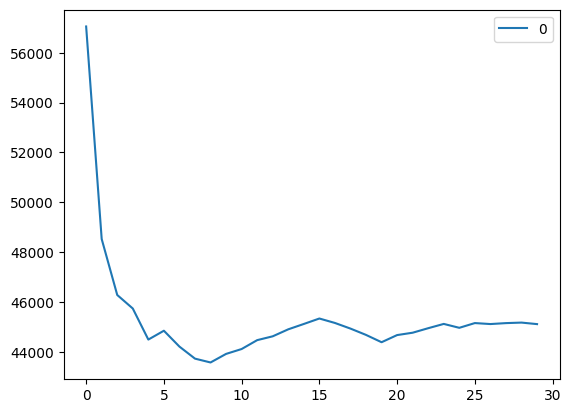

In [51]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve
curve.plot()

## Testing on already known data

In [52]:
model = KNeighborsRegressor(n_neighbors = K_min)
model.fit(X_train, y_train)  # fit the model
pred = model.predict(X_test) #make prediction on test set
print(model.score(X_test, y_test) * 100)
predictions = pd.DataFrame({
    'Id':X_test.Id,
    'Actual_SalePrice': y_test,
    'Predicted_SalePrice':pred,
})

# Saving the model
filename = 'house_model.sav'
pickle.dump(model, open(filename, 'wb'))

predictions

73.31634257750169


,Id,Actual_SalePrice,Predicted_SalePrice
389,390,426000,341296.111111
293,294,235000,206022.222222
1162,1163,129000,135611.111111
600,601,275000,244910.333333
353,354,105900,102927.777778
...,...,...,...
685,686,207500,215500.000000
874,875,66500,119866.666667
580,581,181900,189408.333333
1356,1357,110000,118555.555556


## Testing on the new data

In [53]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.fit(X_train, y_train)  #fit the model
pred=model.predict(test_data_processed) #make prediction on test set
predictions = pd.DataFrame({
    'Id':test_data_processed.Id,
    'SalePrice':pred,
})

predictions

,Id,SalePrice
0,1461,122866.666667
1,1462,168510.000000
2,1463,177704.444444
3,1464,169448.888889
4,1465,177704.444444
...,...,...
1454,2915,106755.555556
1455,2916,124061.111111
1456,2917,171948.888889
1457,2918,117394.444444
